# Multimodal Network

Create GNN for each of the dimensions and later combine them into a single network.

1. Each dimension is a separate graph and gets its own GNN.
2. Dimensions are connected in a MLP layer.

Add the Gini value as a node-feature and masking it to prevent data-leakage.

#### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import country_converter as coco
import functools
import os
from torchmetrics.regression import MeanAbsolutePercentageError

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.chdir('/home/jovyan/dlss-project')
print("Current working directory:", os.getcwd())

cuda
Current working directory: /home/jovyan/dlss-project


## Data

In [2]:
path_geo_edges = "data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "data_collection/political/data/edge_features.parquet"
path_pol_nodes = "data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "data_collection/culture/culture_edges.parquet"
path_cult_nodes = "data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "data_collection/economics/edges_economics.parquet"
path_eco_nodes = "data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

path_gini = "data_collection/gini.parquet"
df_gini = pd.read_parquet(path_gini)
df_gini = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)

In [3]:
@functools.lru_cache(maxsize=1)
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric

@functools.lru_cache(maxsize=1000)
def convert_country_code(country, target_format='UNnumeric'):
    """Cache country code conversions"""
    return coco.convert(names=country, to=target_format, not_found=None)

def df_preparation(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    # Get UN countries once
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Pre-filter dataframes
    edge_mask = edge_df[edge_country_a_col].isin(uno_iso3_codes) & edge_df[edge_country_b_col].isin(uno_iso3_codes)
    node_mask = node_df[node_country_col].isin(uno_iso3_codes)

    edge_df = edge_df[edge_mask].copy()
    node_df = node_df[node_mask].copy()

    # Ensure year is int before unique extraction
    edge_df[year_col] = edge_df[year_col].astype(int)
    node_df[year_col] = node_df[year_col].astype(int)

    # Vectorized country code conversion
    unique_countries_edges = pd.concat([edge_df[edge_country_a_col], edge_df[edge_country_b_col]]).unique()
    unique_countries_nodes = node_df[node_country_col].unique()
    all_unique_countries = np.unique(np.concatenate([unique_countries_edges, unique_countries_nodes]))

    country_to_id_map = dict(zip(
        all_unique_countries,
        coco.convert(all_unique_countries.tolist(), to='UNnumeric', not_found=None)
    ))

    # Apply mapping
    edge_df['country_id_a'] = edge_df[edge_country_a_col].map(country_to_id_map)
    edge_df['country_id_b'] = edge_df[edge_country_b_col].map(country_to_id_map)
    node_df['country_id'] = node_df[node_country_col].map(country_to_id_map)

    # Drop any rows where mapping failed (shouldn't if filters were correct)
    edge_df = edge_df.dropna(subset=['country_id_a', 'country_id_b'])
    node_df = node_df.dropna(subset=['country_id'])

    # Cast country_id to int
    edge_df['country_id_a'] = edge_df['country_id_a'].astype(int)
    edge_df['country_id_b'] = edge_df['country_id_b'].astype(int)
    node_df['country_id'] = node_df['country_id'].astype(int)
    
    edge_features_cols = [
        col for col in edge_df.columns
        if col not in [edge_country_a_col, edge_country_b_col, year_col, 'country_id_a', 'country_id_b']
    ]
    node_features_cols = [
        col for col in node_df.columns
        if col not in [node_country_col, year_col, 'country_id']
    ]
    
    edge_df_processed = edge_df.copy()[['country_id_a', 'country_id_b', year_col] + edge_features_cols]
    node_df_processed = node_df.copy()[['country_id', year_col] + node_features_cols]
    
    return node_df_processed, edge_df_processed

def preprocess_gini(df_gini, year_col='year', country_col='country', gini_col='gini'):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Filter Gini data for UN countries
    df_gini = df_gini[df_gini[country_col].isin(uno_iso3_codes)].copy()
    
    # Convert country codes to UN numeric
    df_gini['country_id'] = df_gini[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    
    df_gini = df_gini.sort_values(by=['country_id']).reset_index(drop=True)
    
    # Drop rows with NaN country_id
    df_gini = df_gini.dropna(subset=['country_id'])
    
    # Normalize Gini values to [0, 1] range for each year
    df_gini[gini_col] = df_gini[gini_col] / 100
    
    # create mask column to indicate if country exists in this year
    df_gini['exists'] = 1
    df_gini.loc[df_gini[gini_col].isna(), 'exists'] = 0
    
    df_gini.loc[df_gini[gini_col].isna(), gini_col] = 0  # Fill NaN Gini values with 0
    
    return df_gini[['country_id', year_col, gini_col, 'exists']].copy()

def create_data_yearly(node_df, edge_df, year, mask_col, year_col='year',):
        
    edge_df_year = edge_df[edge_df[year_col] == year]
    node_df_year = node_df[node_df[year_col] == year].copy()  # copy because we'll potentially modify
    
    # drop dupicate rows in node_df_year
    node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')
            
    # --- Edge features ---
    edge_features_cols = [
        col for col in edge_df_year.columns
        if col not in ['country_id_a', 'country_id_b', year_col]
    ]
    edge_features_df = edge_df_year[edge_features_cols].copy()
    
    # Coerce all edge feature columns to numeric, fill NaN with 0
    edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # --- Node features ---
    node_features_cols = [
        col for col in node_df_year.columns
        if col not in ['country_id', year_col, mask_col]
    ]
    # TODO: maybe also remove 'exists' column
        
    # Ensure node_df_year is sorted by country_id and align features accordingly
    node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)
        
    # select only feature columns
    node_df_year_features = node_df_year_sorted[node_features_cols].copy()
    
    mask_col_tensor = torch.tensor(node_df_year_sorted[mask_col].values, dtype=torch.float32)
    
    country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)
    
    # --- Tensor creation ---
    edge_features_array = edge_features_df.values.astype(np.float32)
    edge_attr = torch.from_numpy(edge_features_array)

    
    node_df_year_features = node_df_year_features.apply(pd.to_numeric, errors='coerce').fillna(0)
    node_features_tensor = torch.tensor(node_df_year_features.values, dtype=torch.float32)
    
    
    # Build a mapping from country_id to its position in the sorted node list
    country_id_to_pos = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}
    
    # Map edge indices to positions in the sorted node list
    edge_index = torch.tensor(
        [
        edge_df_year['country_id_a'].map(country_id_to_pos).values,
        edge_df_year['country_id_b'].map(country_id_to_pos).values
        ],
        dtype=torch.long
    )
    data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, country_id = country_id_tensor, mask=mask_col_tensor)
    
    return data

def scale_data(node_df, edge_df, node_features_cols, edge_feature_cols):
    """
    Scale node and edge dataframes using StandardScaler.
    """
    # apply standardization to node features
    node_scaler = StandardScaler()
    edge_scaler = StandardScaler()
    
    # fit standard scaler on train set
    
    # create subset of only training rows to fit scaler
    node_df_train_subset = node_df[node_df['train_mask'] == 1]
    node_scaler.fit(node_df_train_subset[node_features_cols])
    
    # filter edge_df to only include training countries
    edge_df_train_subset = edge_df[edge_df['country_id_a'].isin(node_df_train_subset['country_id']) & 
                                   edge_df['country_id_b'].isin(node_df_train_subset['country_id'])]
    edge_scaler.fit(edge_df_train_subset[edge_feature_cols])
    
    # apply scaler to all node dataframes
    node_df[node_features_cols] = node_scaler.transform(node_df[node_features_cols])
    edge_df[edge_feature_cols] = edge_scaler.transform(edge_df[edge_feature_cols])
    
    return node_df, edge_df

def create_network_data(node_df, edge_df, gini_df):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()
    
    # convert boolean columns to int
    bool_cols_nodes = node_df.select_dtypes(include='bool').columns
    if len(bool_cols_nodes) > 0:
        node_df[bool_cols_nodes] = node_df[bool_cols_nodes].astype(int)
    bool_cols_edges = edge_df.select_dtypes(include='bool').columns
    if len(bool_cols_edges) > 0:
        edge_df[bool_cols_edges] = edge_df[bool_cols_edges].astype(int)
    
    # fill in all missing countries with 0 values for the years from 2000 to 2022
    all_years = range(2000, 2023)
    all_countries = uno_unnumeric_codes
    
    # Create a MultiIndex of all combinations
    full_index = pd.MultiIndex.from_product([all_countries, all_years], names=['country_id', 'year'])
    node_df = node_df.set_index(['country_id', 'year'])
    node_df = node_df.reindex(full_index, fill_value=0).reset_index()
        
    # Fill missing feature columns with 0 (if any NaNs)
    node_features_cols = [col for col in node_df.columns if col not in ['country_id', 'year']]
    node_df[node_features_cols] = node_df[node_features_cols].fillna(0)
    
    edge_feature_cols = [col for col in edge_df.columns if col not in ['country_id_a', 'country_id_b', 'year']]
    
    # merge node_df with gini_df
    node_df_merged = node_df.merge(gini_df, on=['country_id', 'year'])
    
    node_df_merged, edge_df = scale_data(node_df_merged, edge_df, node_features_cols, edge_feature_cols)
    
    # generate train, val and test set.
    # set gini to 0 at respected masks
    
    node_df_train = node_df_merged.copy().drop(columns=['val_mask', 'test_mask'], errors='ignore')
    node_df_val = node_df_merged.copy().drop(columns=['train_mask', 'test_mask'], errors='ignore')
    node_df_test = node_df_merged.copy().drop(columns=['train_mask', 'val_mask'], errors='ignore')
    
    # set gini to 0 where train_mask is 1
    node_df_train.loc[gini_df['train_mask'] == 1, 'gini'] = 0
    node_df_val.loc[gini_df['val_mask'] == 1, 'gini'] = 0
    node_df_test.loc[gini_df['test_mask'] == 1, 'gini'] = 0
    
    
    # limit years from 2000 to 2022
    years = [year for year in range(2000, 2023)]
    
    data_dict = {}
    # create data for each year
    
    for year in years:
        data_train = create_data_yearly(node_df_train, edge_df, year, 'train_mask', year_col='year')
        data_val = create_data_yearly(node_df_val, edge_df, year, 'val_mask', year_col='year')
        data_test = create_data_yearly(node_df_test, edge_df, year, 'test_mask', year_col='year')
        data_dict[year] = {
            'train': data_train,
            'val': data_val,
            'test': data_test
        }
    
    return data_dict

def create_gini_data(gini_df, year_col='year'):
    
    gini_dict = {}
    
    for year in range(2000, 2023):
        gini_df_year = gini_df[gini_df[year_col] == year].copy()

        # convert to tensor
        gini_tensor = torch.tensor(gini_df_year['gini'].values, dtype=torch.float32)
        country_id_tensor = torch.tensor(gini_df_year['country_id'].values, dtype=torch.long)
        train_mask_tensor = torch.tensor(gini_df_year['train_mask'].values, dtype=torch.bool)
        val_mask_tensor = torch.tensor(gini_df_year['val_mask'].values, dtype=torch.bool)
        test_mask_tensor = torch.tensor(gini_df_year['test_mask'].values, dtype=torch.bool)
        
        
        
        gini_dict[year] = {
            'train': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=train_mask_tensor),
            'val': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=val_mask_tensor),
            'test': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=test_mask_tensor)
        }
        
    return gini_dict
            

def create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split all available (exists==1) rows in gini_df into train/val/test and create mask columns.
    Adds 'train_mask', 'val_mask', 'test_mask' columns to gini_df (0/1 values).
    """
    df = gini_df.copy()
    available_idx = df.index[df['exists'] == 1].tolist()
    train_idx, test_idx = train_test_split(available_idx, test_size=test_size, random_state=random_state)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_size, random_state=random_state)
    
    df['train_mask'] = 0
    df['val_mask'] = 0
    df['test_mask'] = 0
    df.loc[train_idx, 'train_mask'] = 1
    df.loc[val_idx, 'val_mask'] = 1
    df.loc[test_idx, 'test_mask'] = 1
    return df

def create_data(data_combined, gini_df):
    
    # create gini train, val and test masks
    # perform train-val-test split on gini_data for all available values
    
    gini_df = create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42)
    
    data_dict = {}
    
    for modality, data in data_combined.items():
        nodes = data['nodes']
        edges = data['edges']
        data_dict[modality] = create_network_data(nodes, edges, gini_df)
        
    # add gini data
    gini_data = create_gini_data(gini_df)
    data_dict['gini'] = gini_data
    
    data_dict_reform = {}
    # reform data_dict to have years as keys
    for year in range(2000, 2023):
        data_dict_reform[year] = {
            'political': data_dict['political'][year],
            'geography': data_dict['geography'][year],
            'culture': data_dict['culture'][year],
            'language': data_dict['language'][year],
            'economy': data_dict['economy'][year],
            'gini': gini_data[year]
        }
    
    # reform again to have train, val, test as subkeys -> data_dict_reform[year]['train'], data_dict_reform[year]['val'], data_dict_reform[year]['test']
    for year in data_dict_reform.keys():
        data_dict_reform[year] = {
            'train': {
                'political': data_dict_reform[year]['political']['train'],
                'geography': data_dict_reform[year]['geography']['train'],
                'culture': data_dict_reform[year]['culture']['train'],
                'language': data_dict_reform[year]['language']['train'],
                'economy': data_dict_reform[year]['economy']['train'],
                'gini': data_dict_reform[year]['gini']['train']
            },
            'val': {
                'political': data_dict_reform[year]['political']['val'],
                'geography': data_dict_reform[year]['geography']['val'],
                'culture': data_dict_reform[year]['culture']['val'],
                'language': data_dict_reform[year]['language']['val'],
                'economy': data_dict_reform[year]['economy']['val'],
                'gini': data_dict_reform[year]['gini']['val']
            },
            'test': {
                'political': data_dict_reform[year]['political']['test'],
                'geography': data_dict_reform[year]['geography']['test'],
                'culture': data_dict_reform[year]['culture']['test'],
                'language': data_dict_reform[year]['language']['test'],
                'economy': data_dict_reform[year]['economy']['test'],
                'gini': data_dict_reform[year]['gini']['test']
            }
        }
        
    return data_dict_reform

In [4]:
geo_nodes, geo_edges = df_preparation(df_geo_edges, df_geo_nodes, 
                        edge_country_a_col='iso_o', edge_country_b_col='iso_d',
                        node_country_col='code_3', year_col='year')

pol_nodes, pol_edges = df_preparation(df_pol_edges, df_pol_nodes,
                        edge_country_a_col='state1', edge_country_b_col='state2',
                        node_country_col='country', year_col='year')

cul_nodes, cul_edges = df_preparation(df_cult_edges, df_cult_nodes,
                        edge_country_a_col='ISO3_a', edge_country_b_col='ISO3_b',
                        node_country_col='ISO3', year_col='year')

lang_nodes, lang_edges = df_preparation(df_lang_edges, df_lang_nodes,
                        edge_country_a_col='country_a', edge_country_b_col='country_b',
                        node_country_col='ISO3', year_col='year')

eco_nodes, eco_edges = df_preparation(df_eco_edges, df_eco_nodes,
                        edge_country_a_col='src_ISO3', edge_country_b_col='tgt_ISO3',
                        node_country_col='ISO3', year_col='year')

data_combined = {
    'geography': {'nodes': geo_nodes, 'edges': geo_edges},
    'political': {'nodes': pol_nodes, 'edges': pol_edges},
    'culture': {'nodes': cul_nodes, 'edges': cul_edges},
    'language': {'nodes': lang_nodes, 'edges': lang_edges},
    'economy': {'nodes': eco_nodes, 'edges': eco_edges}
}

df_gini_processed = preprocess_gini(df_gini)

In [5]:
data_dict = create_data(data_combined, df_gini_processed)

/tmp/ipykernel_816/1569791298.py:139: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(


In [6]:
data_dict[2000]['train']['political'].x

tensor([[-2.0361, -1.7419, -1.9230,  ..., -2.5128,  0.0000,  0.0000],
        [-0.7807, -0.5819, -0.7201,  ..., -1.0274,  0.0000,  0.0000],
        [-1.1020, -1.2743, -1.2865,  ..., -1.4988,  0.0000,  0.0000],
        ...,
        [-2.3089, -1.8205, -1.9838,  ..., -0.2482,  0.0000,  0.0000],
        [-1.3224, -1.3422, -1.4643,  ..., -1.3853,  0.0000,  0.0000],
        [-0.4780, -0.4534, -0.4815,  ..., -0.8735,  0.0000,  0.0000]])

In [7]:
# get the dimesions of each network: number of node_features, number of edge-features
network_dimesions = {
    'geography': {
        'node_features': data_dict[2000]['train']['geography'].x.shape[1],
        'edge_features': data_dict[2000]['train']['geography'].edge_attr.shape[1]
    },
    'political': {
        'node_features': data_dict[2000]['train']['political'].x.shape[1],
        'edge_features': data_dict[2000]['train']['political'].edge_attr.shape[1]
    },
    'culture': {
        'node_features': data_dict[2000]['train']['culture'].x.shape[1],
        'edge_features': data_dict[2000]['train']['culture'].edge_attr.shape[1]
    },
    'language': {
        'node_features': data_dict[2000]['train']['language'].x.shape[1],
        'edge_features': data_dict[2000]['train']['language'].edge_attr.shape[1]
    },
    'economy': {
        'node_features': data_dict[2000]['train']['economy'].x.shape[1],
        'edge_features': data_dict[2000]['train']['economy'].edge_attr.shape[1]
        },  # Placeholder for future economy data
}

In [8]:
network_dimesions

{'geography': {'node_features': 30, 'edge_features': 16},
 'political': {'node_features': 9, 'edge_features': 5},
 'culture': {'node_features': 8, 'edge_features': 11},
 'language': {'node_features': 9, 'edge_features': 2},
 'economy': {'node_features': 5, 'edge_features': 1}}

## Model Setup

In [9]:
# GNN model for each of the different networks
class DimensionModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_size=64, target_size=1, n_gat_layers=2, n_mlp_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_node_features = num_node_features
        self.num_edge_features = num_edge_features
        self.target_size = target_size
        # Dynamically create GAT layers
        self.convs = nn.ModuleList()
        self.convs.append(GATv2Conv(self.num_node_features, self.hidden_size, edge_dim=num_edge_features))
        for _ in range(n_gat_layers - 1):
            self.convs.append(GATv2Conv(self.hidden_size, self.hidden_size, edge_dim=num_edge_features))

        # Dynamically create MLP layers
        self.n_mlp_layers = n_mlp_layers
        mlp_layers = []
        for _ in range(n_mlp_layers):
            mlp_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.2))
        self.mlp = nn.Sequential(*mlp_layers)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        if self.n_mlp_layers > 0:
            x = self.mlp(x)  # Apply the fully connected layer
        return x
    
class MultiModalGNNModel(nn.Module):
    def __init__(self, 
                 input_dims,
                 hidden_size=64,
                 final_output_size=1, 
                 n_gat_layers=2,
                 n_dim_mlp_layers=2,
                 combination_method='concat',
                 mlp_variant='default'):
        super().__init__()
        self.combination_method = combination_method

        self.geo_model = DimensionModel(input_dims['geography']['node_features'], input_dims['geography']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.pol_model = DimensionModel(input_dims['political']['node_features'], input_dims['political']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.cult_model = DimensionModel(input_dims['culture']['node_features'], input_dims['culture']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.lang_model = DimensionModel(input_dims['language']['node_features'], input_dims['language']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.eco_model = DimensionModel(input_dims['economy']['node_features'], input_dims['economy']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)

        self.num_modalities = 5
        self.hidden_size = hidden_size

        if self.combination_method == 'attention':
            # Learnable attention weights for each modality
            self.attn_weights = nn.Parameter(torch.ones(self.num_modalities))

        self.fusion_input_size = hidden_size * self.num_modalities if combination_method == 'concat' else hidden_size
        if mlp_variant == 'default':
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, final_output_size)
            )
        elif mlp_variant == 'deep':
            # Deeper MLP variant
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, final_output_size)
            )
        elif mlp_variant == 'shallow':
            # Shallow MLP variant
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, final_output_size)
            )        
    

    def forward(self, data_dict):
        geo_emb = self.geo_model(data_dict['geography'])
        pol_emb = self.pol_model(data_dict['political'])
        cult_emb = self.cult_model(data_dict['culture'])
        lang_emb = self.lang_model(data_dict['language'])
        eco_emb = self.eco_model(data_dict['economy'])

        embeddings = [geo_emb, pol_emb, cult_emb, lang_emb, eco_emb]

        if self.combination_method == 'concat':
            # Concatenate embeddings along the last dimension
            fused = torch.cat(embeddings, dim=-1)
        elif self.combination_method == 'attention':
            # Stack embeddings: shape [num_nodes, num_modalities, hidden_size]
            stacked = torch.stack(embeddings, dim=1)  # [num_nodes, num_modalities, hidden_size]
            attn = torch.softmax(self.attn_weights, dim=0)  # [num_modalities]
            attn = attn.view(1, self.num_modalities, 1)     # [1, num_modalities, 1] for broadcasting
            fused = (stacked * attn).sum(dim=1)             # [num_nodes, hidden_size]
        output = self.mlp(fused)
        return output


## Training Setup

In [10]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt', printing=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model
        self.printing = printing
        
        # remove model if path already exists
        if os.path.exists(path):
          os.remove(path)
          
          if self.printing:
            print(f"Removing existing model at: {path}")

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        if self.printing:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        
def train_gnn(epochs, model, optimizer, criterion, dataloader, early_stopper, printing=True):    
    # Make sure device is defined
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the data and model to the device
    # data_dict = move_data_to_device(data_dict, device)

    # model = model.to(device)

    train_losses = []
    val_losses = []
    
    if printing:
        print("Starting training...")

    for epoch in range(epochs):
        model.train()
        train_loss_temp = 0
        val_loss_temp = 0
        num_batches = 0
        for data_dict in dataloader:
            # Training

            optimizer.zero_grad()

            # Forward pass on the entire graph
            output = model(data_dict['train'])
            mask = data_dict['train']['gini'].mask
            target = data_dict['train']['gini'].y
            
            output_masked = output[mask]
            target_masked = target[mask]

            # Calculate loss using only valid entries
            train_loss = criterion(output_masked, target_masked)

            # Backward pass
            train_loss.backward()
            optimizer.step()
            train_loss_temp += train_loss.item()
            
            num_batches += 1

        # Validation
            model.eval()
            with torch.no_grad():
                output = model(data_dict['val'])
                mask = data_dict['val']['gini'].mask
                target = data_dict['val']['gini'].y
                
                target_masked = target[mask]
                output_masked = output[mask]
                
                val_loss = criterion(output[mask], target[mask])
                val_loss_temp += val_loss.item()
        
        avg_train_loss = train_loss_temp / num_batches
        avg_val_loss = val_loss_temp / num_batches
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        if printing:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            if printing:
                print(f'Early stopping at epoch {epoch+1} with validation loss {val_loss.item():.4f}')
            break

    # Load the best model weights
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses

## Training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        for k2, v2 in v.items():
            if isinstance(v2, Data):
                # Move Data object to device
                v[k2] = v2.to(device)
            elif isinstance(v2, torch.Tensor):
                # Move tensor to device
                v[k2] = v2.to(device)
            else:
                # Leave other types unchanged
                v[k2] = v2
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

data_set = [data_dict[year] for year in data_dict.keys()]

data_set = [move_data_dict_to_device(d, device) for d in data_set]

data_loader = DataLoader(data_set, batch_size=3, shuffle=True)

In [12]:
next(iter(data_loader))['train']  # Check if DataLoader works

{'political': DataBatch(x=[579, 9], edge_index=[2, 3740], edge_attr=[3740, 5], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'geography': DataBatch(x=[579, 30], edge_index=[2, 102120], edge_attr=[102120, 16], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'culture': DataBatch(x=[579, 8], edge_index=[2, 23710], edge_attr=[23710, 11], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'language': DataBatch(x=[579, 9], edge_index=[2, 111168], edge_attr=[111168, 2], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'economy': DataBatch(x=[579, 5], edge_index=[2, 75500], edge_attr=[75500, 1], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'gini': DataBatch(y=[579, 1], country_id=[579], mask=[579])}

Removing existing model at: model_checkpoints/gan_gini_checkpoint.pt
Starting training...
Epoch: 1, Training Loss: 0.1484, Validation Loss: 0.1385
Validation loss decreased (0.138481 --> 0.138481).  Saving model ...
Epoch: 2, Training Loss: 0.0726, Validation Loss: 0.0571
Validation loss decreased (0.138481 --> 0.057092).  Saving model ...
Epoch: 3, Training Loss: 0.1103, Validation Loss: 0.0973
Epoch: 4, Training Loss: 0.0498, Validation Loss: 0.0559
Validation loss decreased (0.057092 --> 0.055855).  Saving model ...
Epoch: 5, Training Loss: 0.0527, Validation Loss: 0.0588
Epoch: 6, Training Loss: 0.0541, Validation Loss: 0.0354
Validation loss decreased (0.055855 --> 0.035418).  Saving model ...
Epoch: 7, Training Loss: 0.0893, Validation Loss: 0.0555
Epoch: 8, Training Loss: 0.0686, Validation Loss: 0.0441
Epoch: 9, Training Loss: 0.0550, Validation Loss: 0.0569
Epoch: 10, Training Loss: 0.0549, Validation Loss: 0.0673
Epoch: 11, Training Loss: 0.0461, Validation Loss: 0.0391
Epoch

Text(0.5, 1.0, 'Training Progress')

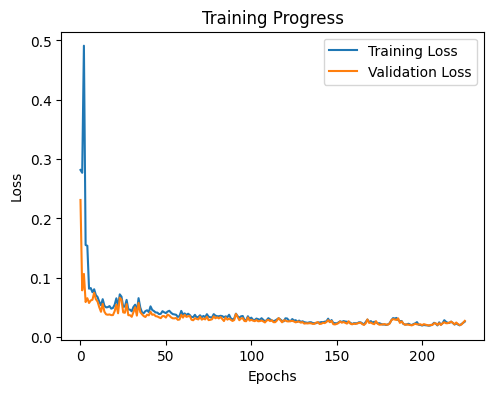

In [13]:
params = {
    'lr': 0.0007833189943995176,
    'weight_decay': 0.00001558,
    'hidden_size': 50
}


gan_model = MultiModalGNNModel(
    input_dims=network_dimesions, hidden_size=params['hidden_size'], 
    n_gat_layers=2, n_dim_mlp_layers=1, combination_method="concat", mlp_variant="deep")

gan_model = gan_model.to(device)

# criterion for regression task
criterion = nn.L1Loss()

# Fix 7: Better optimizer settings for this problem
optimizer = optim.Adam(gan_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])  # Lower LR and weight decay

# Initialize early stopping
early_stopper = EarlyStopping(patience=60, min_delta=0.00001, path='model_checkpoints/gan_gini_checkpoint.pt')

# Train the model
epochs = 1000
train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, data_loader, early_stopper)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gan, label='Training Loss')
plt.plot(val_losses_gan, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')

## Evaluation

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate_model(model, dataloader, device, set='test', printing=True):
    model.eval()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for data_dict in dataloader:
            output = model(data_dict[set])
            mask = data_dict[set]['gini'].mask
            true = data_dict[set]['gini'].y[mask==1].cpu().numpy()
            pred = output[mask==1].cpu().numpy()
            all_true.append(true)
            all_pred.append(pred)
    # Concatenate results from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    
    # Calculate mean percentage error (MPE)
    mape = mean_absolute_percentage_error(all_true,all_pred)
    mae = mean_absolute_error(all_true, all_pred)
    rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    r2 = r2_score(all_true, all_pred)
    
    if printing:

        print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.4f}%")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R^2 Score: {r2:.4f}")

        # Visualization: Predicted vs True
        plt.figure(figsize=(6, 5))
        plt.scatter(all_true, all_pred, alpha=0.5)
        plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--', label="Perfect Prediction")
        plt.xlabel('True GINI')
        plt.ylabel('Predicted GINI')
        plt.title('Predicted vs True GINI (Test Set)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Visualization: Residuals
        residuals = all_true - all_pred
        plt.figure(figsize=(6, 5))
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('Residual (True - Predicted)')
        plt.ylabel('Frequency')
        plt.title('Residuals Distribution')
        plt.tight_layout()
        plt.show()
    
    return all_true, all_pred

Mean Absolute Percentage Error (MAPE): 5.9126%
Mean Absolute Error (MAE): 0.0218
Root Mean Squared Error (RMSE): 0.0297
R^2 Score: 0.8780


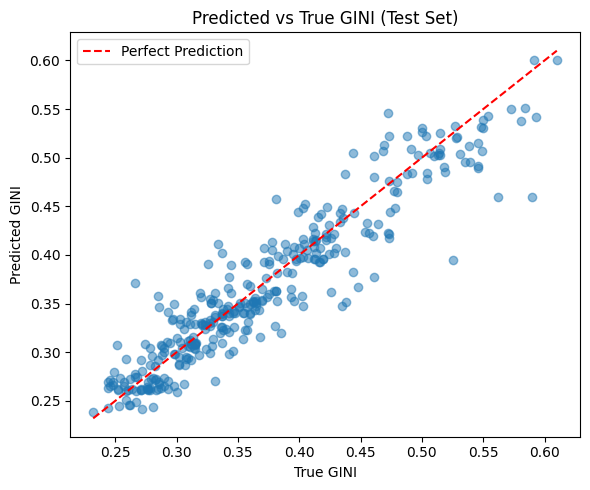

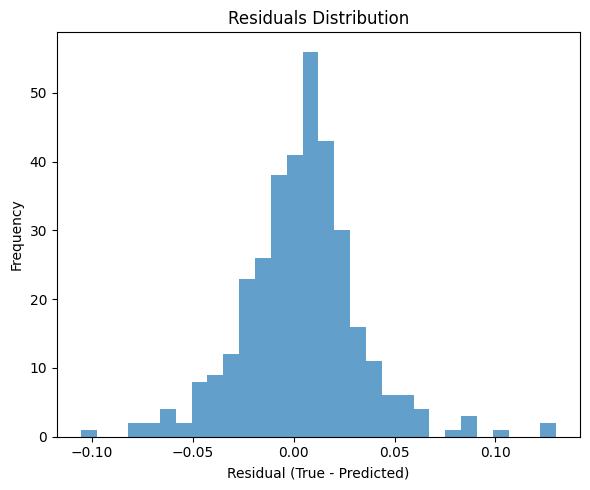

In [15]:
true, pred = evaluate_model(gan_model, data_loader, device, set = 'test')

In [16]:
def analyze_mlp_weights(model):
    
    first_layer_weights = model.mlp[0].weight 
    
    network_weights = torch.split(first_layer_weights, model.hidden_size, dim=1)
    
    # Compute average absolute weight magnitude for each network
    network_importance = [torch.mean(torch.abs(w)).item() for w in network_weights]
    
    return network_importance


In [17]:
# relative importance of each network based on weights in the mlp
importance = analyze_mlp_weights(gan_model)
importance

[0.02502351999282837,
 0.028247369453310966,
 0.02764269709587097,
 0.013509375974535942,
 0.019533595070242882]

In [18]:
total = sum(importance)
percentages = [(v/total)*100 for v in importance]
percentages

[21.958824066592655,
 24.787840253771982,
 24.257223701074277,
 11.854847373962857,
 17.141264604598227]

#### Predicting missing gini data for 2022

In [19]:
def predict_missing_gini_2022(model, data_dict, df_gini_processed, device):
    """
    Predict Gini values for countries with missing data (exists==0) in 2022 only.
    
    Args:
        model: Trained multimodal GNN model
        data_dict: Dictionary containing the processed data for all years
        df_gini_processed: Processed Gini dataframe with exists column
        device: Computing device (CPU/GPU)
    
    Returns:
        DataFrame with predictions for missing Gini values in 2022
    """
    model.eval()
    predictions = []
    
    # Focus only on year 2022
    year = 2022
    
    with torch.no_grad():
        # Get countries with missing Gini data for 2022
        year_gini = df_gini_processed[df_gini_processed['year'] == year]
        missing_mask = year_gini['exists'] == 0
        
        if missing_mask.sum() == 0:
            print("No missing Gini data found for 2022")
            return pd.DataFrame()
        
        print(f"Found {missing_mask.sum()} countries with missing Gini data in 2022")
        
        # Use the test data structure (since we want predictions for all countries)
        year_data = data_dict[year]['test']
        
        # Get model predictions
        output = model(year_data)
        
        # Extract predictions for countries with missing Gini data
        country_ids = year_data['gini'].country_id.cpu().numpy()
        predictions_array = output.cpu().numpy().flatten()
        
        # Create mapping from country_id to prediction
        country_pred_map = dict(zip(country_ids, predictions_array))
        
        # Get missing countries for 2022
        missing_countries = year_gini[missing_mask]['country_id'].values
        
        for country_id in missing_countries:
            if country_id in country_pred_map:
                predictions.append({
                    'year': year,
                    'country_id': country_id,
                    'predicted_gini': country_pred_map[country_id],
                    'original_gini': year_gini[year_gini['country_id'] == country_id]['gini'].iloc[0]
                })
    
    return pd.DataFrame(predictions)

def get_country_names(predictions_df):
    """
    Add country names to the predictions dataframe.
    """
    if len(predictions_df) == 0:
        return predictions_df
    
    # Convert country IDs back to ISO3 codes and then to country names
    country_names = []
    for country_id in predictions_df['country_id']:
        iso3_code = coco.convert(country_id, to='ISO3')
        country_name = coco.convert(iso3_code, to='name_short')
        country_names.append({
            'country_id': country_id,
            'iso3_code': iso3_code,
            'country_name': country_name
        })
    
    country_df = pd.DataFrame(country_names)
    return predictions_df.merge(country_df, on='country_id', how='left')

# Generate predictions for missing Gini values in 2022 only
print("Generating predictions for missing Gini values in 2022...")
missing_gini_predictions_2022 = predict_missing_gini_2022(gan_model, data_dict, df_gini_processed, device)

if len(missing_gini_predictions_2022) > 0:
    # Add country names
    missing_gini_predictions_2022 = get_country_names(missing_gini_predictions_2022)
    
    # Convert predicted Gini back to 0-100 scale (since we normalized to 0-1)
    missing_gini_predictions_2022['predicted_gini_scaled'] = missing_gini_predictions_2022['predicted_gini'] * 100
    
    print(f"Generated {len(missing_gini_predictions_2022)} predictions for missing Gini values in 2022")
    print(f"Countries with missing Gini data in 2022: {missing_gini_predictions_2022['country_name'].nunique()}")
else:
    print("No missing Gini data found for 2022 or no predictions could be generated")

missing_gini_predictions_2022


Generating predictions for missing Gini values in 2022...
Found 132 countries with missing Gini data in 2022
Generated 132 predictions for missing Gini values in 2022
Countries with missing Gini data in 2022: 132


,year,country_id,predicted_gini,original_gini,iso3_code,country_name,predicted_gini_scaled
0,2022,4,0.348680,0.0,AFG,Afghanistan,34.868031
1,2022,8,0.324941,0.0,ALB,Albania,32.494129
2,2022,12,0.337266,0.0,DZA,Algeria,33.726604
3,2022,20,0.096068,0.0,AND,Andorra,9.606754
4,2022,24,0.462999,0.0,AGO,Angola,46.299892
...,...,...,...,...,...,...,...
127,2022,834,0.393564,0.0,TZA,Tanzania,39.356400
128,2022,854,0.367089,0.0,BFA,Burkina Faso,36.708893
129,2022,862,0.478262,0.0,VEN,Venezuela,47.826160
130,2022,882,0.208200,0.0,WSM,Samoa,20.819988


In [20]:
missing_gini_predictions_2022.to_csv('/home/jovyan/dlss-project/df_missing_gini_pred_with_gini.csv')

#### Evaluating of specific test countries

In [21]:
df_gini_2021 = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)


test_countries = ["FRA", "POL", "SWE", "IND", "IRN", "IDN", 
                  "ZMB", "TCD", "USA", "BRA", "MEX", "BTN", "MLT", "SUR"]
test_countries_numeric = coco.convert(test_countries, to="UNnumeric")

In [22]:
# Step 1: Create modified Gini data without 2022 for test countries
def create_evaluation_gini_data(df_gini_original, test_countries):
    """
    Create Gini data excluding 2022 values for specific test countries.
    """
    df_gini_eval = df_gini_original.copy()
    
    # Remove 2022 data for test countries
    mask_to_remove = (df_gini_eval['year'] == 2022) & (df_gini_eval['country'].isin(test_countries))
    df_gini_held_out = df_gini_eval[mask_to_remove].copy()  # Save for evaluation
    df_gini_train = df_gini_eval[~mask_to_remove].reset_index(drop=True)
    
    print(f"Original Gini dataset size: {len(df_gini_original)}")
    print(f"Training Gini dataset size: {len(df_gini_train)} (removed {len(df_gini_held_out)} entries)")
    print(f"Held-out countries for evaluation: {df_gini_held_out['country'].tolist()}")
    
    return df_gini_train, df_gini_held_out

# Create the modified Gini dataset
df_gini_train, df_gini_eval = create_evaluation_gini_data(df_gini, test_countries)

Original Gini dataset size: 4968
Training Gini dataset size: 4954 (removed 14 entries)
Held-out countries for evaluation: ['BRA', 'BTN', 'FRA', 'IDN', 'IND', 'IRN', 'MEX', 'MLT', 'POL', 'SUR', 'SWE', 'TCD', 'USA', 'ZMB']


In [23]:
# Step 2: Update the create_data_yearly function with the fix
def create_data_yearly_fixed(node_df, edge_df, year, mask_col, year_col='year'):
        
    edge_df_year = edge_df[edge_df[year_col] == year]
    node_df_year = node_df[node_df[year_col] == year].copy()  # copy because we'll potentially modify
    
    # drop duplicate rows in node_df_year
    node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')
    
    # Get available countries for this year
    available_countries = set(node_df_year['country_id'].values)
    
    # Filter edges to only include countries that exist in nodes for this year
    edge_df_year = edge_df_year[
        edge_df_year['country_id_a'].isin(available_countries) & 
        edge_df_year['country_id_b'].isin(available_countries)
    ]
            
    # --- Edge features ---
    edge_features_cols = [
        col for col in edge_df_year.columns
        if col not in ['country_id_a', 'country_id_b', year_col]
    ]
    edge_features_df = edge_df_year[edge_features_cols].copy()
    
    # Coerce all edge feature columns to numeric, fill NaN with 0
    edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # --- Node features ---
    node_features_cols = [
        col for col in node_df_year.columns
        if col not in ['country_id', year_col, mask_col]
    ]
        
    # Ensure node_df_year is sorted by country_id and align features accordingly
    node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)
        
    # select only feature columns
    node_df_year_features = node_df_year_sorted[node_features_cols].copy()
    
    mask_col_tensor = torch.tensor(node_df_year_sorted[mask_col].values, dtype=torch.float32)
    
    country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)
    
    # --- Tensor creation ---
    edge_features_array = edge_features_df.values.astype(np.float32)
    edge_attr = torch.from_numpy(edge_features_array)

    
    node_df_year_features = node_df_year_features.apply(pd.to_numeric, errors='coerce').fillna(0)
    node_features_tensor = torch.tensor(node_df_year_features.values, dtype=torch.float32)
    
    
    # Build a mapping from country_id to its position in the sorted node list
    country_id_to_pos = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}
    
    # Map edge indices to positions in the sorted node list - now guaranteed to work
    # since we filtered edges to only include available countries
    edge_index_a = edge_df_year['country_id_a'].map(country_id_to_pos)
    edge_index_b = edge_df_year['country_id_b'].map(country_id_to_pos)
    
    # Check for any remaining NaN values (shouldn't happen after filtering)
    if edge_index_a.isna().any() or edge_index_b.isna().any():
        print(f"Warning: NaN values found in edge mapping for year {year}")
        edge_index_a = edge_index_a.fillna(0)
        edge_index_b = edge_index_b.fillna(0)
    
    edge_index = torch.tensor(
        [edge_index_a.values, edge_index_b.values],
        dtype=torch.long
    )
    
    data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, country_id=country_id_tensor, mask=mask_col_tensor)
    
    return data

# Update the create_network_data function to use the fixed version
def create_network_data_fixed(node_df, edge_df, gini_df):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()
    
    # convert boolean columns to int
    bool_cols_nodes = node_df.select_dtypes(include='bool').columns
    if len(bool_cols_nodes) > 0:
        node_df[bool_cols_nodes] = node_df[bool_cols_nodes].astype(int)
    bool_cols_edges = edge_df.select_dtypes(include='bool').columns
    if len(bool_cols_edges) > 0:
        edge_df[bool_cols_edges] = edge_df[bool_cols_edges].astype(int)
    
    # fill in all missing countries with 0 values for the years from 2000 to 2022
    all_years = range(2000, 2023)
    all_countries = uno_unnumeric_codes
    
    # Create a MultiIndex of all combinations
    full_index = pd.MultiIndex.from_product([all_countries, all_years], names=['country_id', 'year'])
    node_df = node_df.set_index(['country_id', 'year'])
    node_df = node_df.reindex(full_index, fill_value=0).reset_index()
        
    # Fill missing feature columns with 0 (if any NaNs)
    node_features_cols = [col for col in node_df.columns if col not in ['country_id', 'year']]
    node_df[node_features_cols] = node_df[node_features_cols].fillna(0)
    
    edge_feature_cols = [col for col in edge_df.columns if col not in ['country_id_a', 'country_id_b', 'year']]
    
    # merge node_df with gini_df
    node_df_merged = node_df.merge(gini_df, on=['country_id', 'year'])
    
    node_df_merged, edge_df = scale_data(node_df_merged, edge_df, node_features_cols, edge_feature_cols)
    
    # generate train, val and test set.
    # set gini to 0 at respected masks
    
    node_df_train = node_df_merged.copy().drop(columns=['val_mask', 'test_mask'], errors='ignore')
    node_df_val = node_df_merged.copy().drop(columns=['train_mask', 'test_mask'], errors='ignore')
    node_df_test = node_df_merged.copy().drop(columns=['train_mask', 'val_mask'], errors='ignore')
    
    # set gini to 0 where train_mask is 1
    node_df_train.loc[gini_df['train_mask'] == 1, 'gini'] = 0
    node_df_val.loc[gini_df['val_mask'] == 1, 'gini'] = 0
    node_df_test.loc[gini_df['test_mask'] == 1, 'gini'] = 0
    
    
    # limit years from 2000 to 2022
    years = [year for year in range(2000, 2023)]
    
    data_dict = {}
    # create data for each year
    
    for year in years:
        data_train = create_data_yearly_fixed(node_df_train, edge_df, year, 'train_mask', year_col='year')
        data_val = create_data_yearly_fixed(node_df_val, edge_df, year, 'val_mask', year_col='year')
        data_test = create_data_yearly_fixed(node_df_test, edge_df, year, 'test_mask', year_col='year')
        data_dict[year] = {
            'train': data_train,
            'val': data_val,
            'test': data_test
        }
    
    return data_dict

def create_data_fixed(data_combined, gini_df):
    
    # create gini train, val and test masks
    # perform train-val-test split on gini_data for all available values
    
    gini_df = create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42)
    
    data_dict = {}
    
    for modality, data in data_combined.items():
        nodes = data['nodes']
        edges = data['edges']
        data_dict[modality] = create_network_data_fixed(nodes, edges, gini_df)
        
    # add gini data
    gini_data = create_gini_data(gini_df)
    data_dict['gini'] = gini_data
    
    data_dict_reform = {}
    # reform data_dict to have years as keys
    for year in range(2000, 2023):
        data_dict_reform[year] = {
            'political': data_dict['political'][year],
            'geography': data_dict['geography'][year],
            'culture': data_dict['culture'][year],
            'language': data_dict['language'][year],
            'economy': data_dict['economy'][year],
            'gini': gini_data[year]
        }
    
    # reform again to have train, val, test as subkeys -> data_dict_reform[year]['train'], data_dict_reform[year]['val'], data_dict_reform[year]['test']
    for year in data_dict_reform.keys():
        data_dict_reform[year] = {
            'train': {
                'political': data_dict_reform[year]['political']['train'],
                'geography': data_dict_reform[year]['geography']['train'],
                'culture': data_dict_reform[year]['culture']['train'],
                'language': data_dict_reform[year]['language']['train'],
                'economy': data_dict_reform[year]['economy']['train'],
                'gini': data_dict_reform[year]['gini']['train']
            },
            'val': {
                'political': data_dict_reform[year]['political']['val'],
                'geography': data_dict_reform[year]['geography']['val'],
                'culture': data_dict_reform[year]['culture']['val'],
                'language': data_dict_reform[year]['language']['val'],
                'economy': data_dict_reform[year]['economy']['val'],
                'gini': data_dict_reform[year]['gini']['val']
            },
            'test': {
                'political': data_dict_reform[year]['political']['test'],
                'geography': data_dict_reform[year]['geography']['test'],
                'culture': data_dict_reform[year]['culture']['test'],
                'language': data_dict_reform[year]['language']['test'],
                'economy': data_dict_reform[year]['economy']['test'],
                'gini': data_dict_reform[year]['gini']['test']
            }
        }
        
    return data_dict_reform

In [24]:
# Step 3: Recreate the data pipeline with modified Gini data and fixed function
print("Recreating data pipeline with modified Gini dataset...")

# Process the modified Gini data
df_gini_processed_eval = preprocess_gini(df_gini_train)

# Recreate the entire data structure using the fixed functions
data_dict_eval = create_data_fixed(data_combined, df_gini_processed_eval)

print("Data pipeline recreated successfully!")
print(f"Available years: {sorted(data_dict_eval.keys())}")

Recreating data pipeline with modified Gini dataset...
Data pipeline recreated successfully!
Available years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [25]:
# Step 4: Prepare evaluation data
data_set_eval = [data_dict_eval[year] for year in data_dict_eval.keys()]
data_set_eval = [move_data_dict_to_device(d, device) for d in data_set_eval]
data_loader_eval = DataLoader(data_set_eval, batch_size=3, shuffle=True)

print(f"Evaluation data prepared with {len(data_set_eval)} years")

Evaluation data prepared with 23 years


Training model on dataset without 2022 data for test countries...
Removing existing model at: model_checkpoints/gan_eval_checkpoint.pt
Starting training...
Epoch: 1, Training Loss: 0.1290, Validation Loss: 0.1257
Validation loss decreased (0.125665 --> 0.125665).  Saving model ...
Epoch: 2, Training Loss: 0.1492, Validation Loss: 0.1533
Epoch: 3, Training Loss: 0.0619, Validation Loss: 0.0567
Validation loss decreased (0.125665 --> 0.056720).  Saving model ...
Epoch: 4, Training Loss: 0.0599, Validation Loss: 0.0681
Epoch: 5, Training Loss: 0.1059, Validation Loss: 0.1089
Epoch: 6, Training Loss: 0.0673, Validation Loss: 0.0872
Epoch: 7, Training Loss: 0.0762, Validation Loss: 0.0529
Validation loss decreased (0.056720 --> 0.052933).  Saving model ...
Epoch: 8, Training Loss: 0.0551, Validation Loss: 0.0583
Epoch: 9, Training Loss: 0.0545, Validation Loss: 0.0637
Epoch: 10, Training Loss: 0.0704, Validation Loss: 0.0436
Validation loss decreased (0.052933 --> 0.043609).  Saving model .

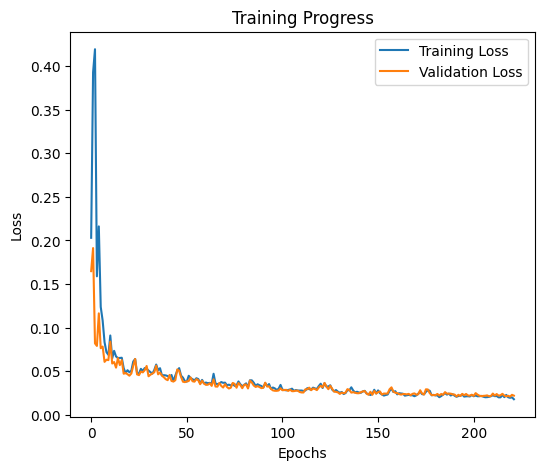

In [26]:
# Step 5: Train new model on modified dataset
print("Training model on dataset without 2022 data for test countries...")

# model
gan_model_eval = MultiModalGNNModel(
    input_dims=network_dimesions, 
    hidden_size=50,
    n_gat_layers=2,
    n_dim_mlp_layers=1,
    combination_method='concat',
    mlp_variant='deep'
)
gan_model_eval = gan_model_eval.to(device)

# Training setup
criterion_eval = nn.L1Loss()
optimizer_eval = optim.Adam(gan_model_eval.parameters(), lr=0.0007833189943995176, weight_decay=0.00001558)
early_stopper_eval = EarlyStopping(patience=60, min_delta=0.00001, path='model_checkpoints/gan_eval_checkpoint.pt')

# Train the model
epochs = 1000
train_losses_eval, val_losses_eval = train_gnn(epochs, gan_model_eval, optimizer_eval, criterion_eval, data_loader_eval, early_stopper_eval)

# Plot training progress
plt.figure(figsize=(6, 5))
plt.plot(train_losses_eval, label='Training Loss')
plt.plot(val_losses_eval, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

Generating predictions for test countries in 2022...
Generated predictions for 14 countries
Test countries with predictions:
  FRA: Actual=31.20, Predicted=34.39
  POL: Actual=28.90, Predicted=31.45
  SWE: Actual=31.60, Predicted=31.25
  IND: Actual=25.50, Predicted=34.80
  IRN: Actual=34.80, Predicted=39.80
  IDN: Actual=35.50, Predicted=39.45
  ZMB: Actual=51.50, Predicted=35.59
  TCD: Actual=37.40, Predicted=44.39
  USA: Actual=41.70, Predicted=37.75
  BRA: Actual=52.00, Predicted=48.46
  MEX: Actual=43.50, Predicted=45.11
  BTN: Actual=28.50, Predicted=51.14
  MLT: Actual=34.60, Predicted=30.46
  SUR: Actual=39.20, Predicted=47.59


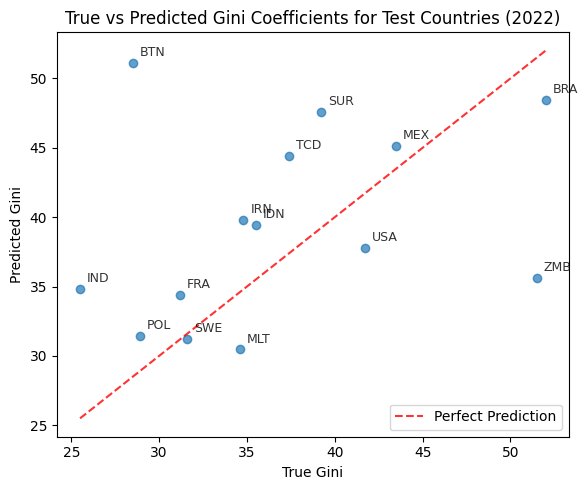


Detailed Results:
Mean Absolute Error: 6.54
Root Mean Square Error: 8.77
Mean Absolute Percentage Error: 18.9%


In [27]:
# Step 6: Predict for test countries in 2022 with visualization
def predict_test_countries_2022(model, data_dict_original, df_gini_eval, test_countries, device):
    """
    Predict Gini values for test countries in 2022 using original data structure.
    """
    model.eval()
    predictions = []
    
    year = 2022
    
    if year not in data_dict_original:
        print(f"Year {year} not available in original data")
        return pd.DataFrame()
    
    with torch.no_grad():
        # Use original data structure for 2022 (has all countries including test countries)
        year_data = data_dict_original[year]['test']  # Use test split
        
        # Get model predictions for all countries
        output = model(year_data)
        
        # Extract country IDs and predictions
        country_ids = year_data['gini'].country_id.cpu().numpy()
        predictions_array = output.cpu().numpy().flatten()
        
        # Create mapping from country_id to prediction
        country_pred_map = dict(zip(country_ids, predictions_array))
        
        # Get predictions for test countries
        for country in test_countries:
            country_id = convert_country_code(country, 'UNnumeric')
            if country_id is not None and country_id in country_pred_map:
                # Get actual Gini value from held-out data
                actual_row = df_gini_eval[df_gini_eval['country'] == country]
                if len(actual_row) > 0:
                    actual_gini = actual_row['gini'].iloc[0]
                    
                    predictions.append({
                        'country': country,
                        'country_id': country_id,
                        'predicted_gini_normalized': country_pred_map[country_id],
                        'actual_gini_original': actual_gini,
                        'predicted_gini_scaled': country_pred_map[country_id] * 100,
                        'actual_gini_normalized': actual_gini / 100
                    })
                else:
                    print(f"Warning: No actual 2022 Gini data found for {country}")
    
    return pd.DataFrame(predictions)

# Make predictions using original data structure (which includes test countries for 2022)
print("Generating predictions for test countries in 2022...")
evaluation_results = predict_test_countries_2022(
    gan_model_eval, data_dict, df_gini_eval, test_countries, device
)

print(f"Generated predictions for {len(evaluation_results)} countries")
if len(evaluation_results) > 0:
    print("Test countries with predictions:")
    for _, row in evaluation_results.iterrows():
        print(f"  {row['country']}: Actual={row['actual_gini_original']:.2f}, Predicted={row['predicted_gini_scaled']:.2f}")
    
    # Create visualization with true vs predicted values
    plt.figure(figsize=(6, 5))
    
    # Extract values for plotting
    true_values = evaluation_results['actual_gini_original'].values
    pred_values = evaluation_results['predicted_gini_scaled'].values
    country_labels = evaluation_results['country'].values
    
    # Create scatter plot
    plt.scatter(true_values, pred_values, alpha=0.7)
    
    # Add country labels to points
    for i, country in enumerate(country_labels):
        plt.annotate(country, (true_values[i], pred_values[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, alpha=0.8)
    
    # Add perfect fit line (y=x)
    min_val = min(min(true_values), min(pred_values))
    max_val = max(max(true_values), max(pred_values))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label="Perfect Prediction")
    
    # Calculate and display metrics
    mae = np.mean(np.abs(true_values - pred_values))
    rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
    mape = np.mean(np.abs((true_values - pred_values) / true_values)) * 100
    
    # Customize plot
    plt.xlabel('True Gini')
    plt.ylabel('Predicted Gini')
    plt.title('True vs Predicted Gini Coefficients for Test Countries (2022)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nDetailed Results:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Square Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape:.1f}%")


## Optuna Optimization

In [28]:
import optuna

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        for k2, v2 in v.items():
            if isinstance(v2, Data):
                # Move Data object to device
                v[k2] = v2.to(device)
            elif isinstance(v2, torch.Tensor):
                # Move tensor to device
                v[k2] = v2.to(device)
            else:
                # Leave other types unchanged
                v[k2] = v2
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

data_set = [data_dict[year] for year in data_dict.keys()]

data_set = [move_data_dict_to_device(d, device) for d in data_set]

def objective(trial):
    
    # set hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 20, 300, step=16)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    
    n_gat_layers = trial.suggest_int("n_gat_layers", 1, 3)
    n_dim_mlp_layers = trial.suggest_int("n_dim_mlp_layers", 0, 3)
    combination_method = trial.suggest_categorical("combination_method", ['concat', 'attention'])
    batch_size = trial.suggest_int("batch_size", 2, 8, step=1)
    
    mlp_variant = trial.suggest_categorical("mlp_variant", ['default', 'deep', 'shallow'])
    
    # prepare training
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)
    
    gan_model = MultiModalGNNModel(
        input_dims=network_dimesions, hidden_size=hidden_size,
        n_gat_layers=n_gat_layers, n_dim_mlp_layers=n_dim_mlp_layers,
        combination_method=combination_method,
        mlp_variant=mlp_variant)
    
    gan_model = gan_model.to(device)
    
    # criterion for regression task
    criterion = MeanAbsolutePercentageError().to(device)
    
    # Fix 7: Better optimizer settings for this problem
    optimizer = optim.Adam(gan_model.parameters(), lr=lr, weight_decay=weight_decay)  # Lower LR and weight decay
    
    # Initialize early stopping
    early_stopper = EarlyStopping(patience=50, min_delta=0.00001, path='model_checkpoints/gan_gini_checkpoint_optuna.pt', printing=False)
    
    # Train the model
    epochs = 1000
    train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, data_loader, early_stopper, printing = False)
    
    # Evaluate the model on the validation set
    true, pred = evaluate_model(gan_model, data_loader, device, set='val', printing =False)
    mape = np.mean(np.abs((true - pred) / np.abs(true))) * 100
    
    return mape

study = optuna.create_study(
    study_name = "Multimodal_with_Gini",
    storage="sqlite:///optuna_with_gini_study.db",
    direction="minimize", 
    load_if_exists=True)
# study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)

[I 2025-08-27 14:40:27,465] Using an existing study with name 'Multimodal_with_Gini' instead of creating a new one.


Best trial:
{'hidden_size': 50, 'weight_decay': 1.5579380006082785e-05, 'lr': 0.0007833189943995176, 'n_gat_layers': 2, 'n_mlp_layers': 1, 'combination_method': 'concat', 'batch_size': 6, 'mlp_variant': 'deep'}
